<a href="https://colab.research.google.com/github/omarn8911/Dphi-MLBootCamp/blob/master/titanic_preprocessing_eda_and_ml_in_python_xpynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction 
This is my first Kaggle experience, and one of the first machine learning projects that I wrote in Python. 

When the RMS Titanic sank in 1912, 1502 out of 2224 passengers and crew members died. There were not enough lifeboats for everyone. In the Hollywood blockbuster that was modelled on this tragedy, it seemed to be the case that upper-class people, women and children were more likely to survive than others. But did these properties (socio-economic status, sex and age) really influence one's survival chances? 

Based on data of a subset of 891 passengers on the Titanic, I will make a model that can be used to predict survival of other Titanic passengers. 

### Outline
In the course of this project I will take the following steps:

- Preprocessing/cleaning of the provided data
- Exploratory analysis of the data
- Preprocessing for machine learning
- Fitting machine learning models
- Predicting test samples

### Preprocessing
First, let's load the training data to see what we're dealing with. We will import the file to a pandas DataFrame:

In [0]:
import pandas as pd
train_data = pd.read_csv('../input/train.csv')

Now, let's take a look at the first few rows of the DataFrame:

In [0]:
train_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


The documentation on Kaggle tells me that the 'Pclass' column contains a number which indicates class of the passenger's ticket:  1 for first class, 2 for second class and 3 for third class. This could function as a proxy for the socio-economic status of the passenger ('upper', 'middle', 'low'). The 'SibSp' column contains the number of siblings + spouses of the passenger also aboard the Titanic; the 'ParCh' column indicates the number of parents + children of the passenger also aboard the Titanic. The 'Ticket' column contains the ticket numbers of passengers (which are not likely to have any predictive power regarding survival); 'Cabin' contains the cabin number of the passenger, if he/she had a cabin, and lastly, 'Embarked' indicates the port of embarkation of the passenger: **C**herbourg, **Q**ueenstown or **S**outhampton. The meaning of the other columns is clear, I think.

Let's check some more info on the DataFrame: 

In [0]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


The DataFrame contains 891 entries in total, with 12 features. Of those 12 features, 10 have non-null values for every entry, and 2 do not: 'Age', which has 714 non-null entries, and 'Cabin', which has only 204 non-null entries (of course, not everyone had a cabin).

First of all, the DataFrame index does not correspond to the PassengerId column. Let's check if the values in PassengerId are unique using numpy.unique():

In [0]:
import numpy as np
(np.unique(train_data['PassengerId'].values).size, 
np.unique(train_data['PassengerId'].values).size == train_data.shape[0])

(891, True)

There are 891 unique values in the PassengerId column, which equals to the total 891 id values, so every entry has an unique value in that column. Let's set the index of our DataFrame to that column, since the PassengerId is assigned arbitrarily and thus should not be regarded a real 'feature' of the data:

In [0]:
train_data.set_index(['PassengerId'], inplace=True)
train_data.head(0)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,


PassengerId has now been set as the DataFrame index. 

I don't expect the 'Name' feature to be of any value to our classification problem in its raw form, since all or at least most people will have a unique name. We could, however, extract the titles (Mr., Miss. etc.) of the passengers and use the title as a categorical/nominal feature. In the 'Name' column of our DataFrame, the titles are followed by a '.', which will help us extracting them. We'll make use of regex:

In [0]:
import re
patt = re.compile('\s(\S+\.)') # 1 whitespace character followed by several 
# non-whitespace characters followed by a dot

titles = np.array([re.search(patt, i)[1] for i in train_data['Name'].values])

print('Unique titles ({}): \n{}'.format(np.unique(titles).shape[0], np.unique(titles)))
print('')
print('Number of titles that are NaN/Null: {}'.format(pd.isnull(titles).sum()))

Unique titles (17): 
['Capt.' 'Col.' 'Countess.' 'Don.' 'Dr.' 'Jonkheer.' 'Lady.' 'Major.'
 'Master.' 'Miss.' 'Mlle.' 'Mme.' 'Mr.' 'Mrs.' 'Ms.' 'Rev.' 'Sir.']

Number of titles that are NaN/Null: 0


We'll include the titles as a new feature 'Title' in the DataFrame, and drop the 'Name' feature:

In [0]:
train_data = train_data.assign(Title=titles)
train_data = train_data.drop('Name', axis=1)

We can count the number of occurrences for each title:

In [0]:
train_data['Title'].groupby(train_data['Title']).size()

Title
Capt.          1
Col.           2
Countess.      1
Don.           1
Dr.            7
Jonkheer.      1
Lady.          1
Major.         2
Master.       40
Miss.        182
Mlle.          2
Mme.           1
Mr.          517
Mrs.         125
Ms.            1
Rev.           6
Sir.           1
dtype: int64

We observe that most of the titles occur very infrequently. Fitting our models to these titles might mean we would be overfitting. Let's group 'Mlle' and 'Mme' with their English counterparts 'Miss' and 'Mrs'. 'Ms' will be grouped with 'Miss'; 'Capt', 'Col' and 'Major' will be put in an 'Army' category, and 'Countess', 'Don', 'Jonkheer', 'Lady' and 'Sir' will be put in a 'Noble' category. 'Dr' will be kept as a category:

In [0]:
train_data['Title'] = train_data['Title'].replace('Mlle.','Miss.')
train_data['Title'] = train_data['Title'].replace('Ms.','Miss.')  
train_data['Title'] = train_data['Title'].replace('Mme.','Mrs.')
train_data['Title'] = train_data['Title'].replace(['Capt.','Col.','Major.'],'Army.')
train_data['Title'] = train_data['Title'].replace(['Countess.','Don.','Jonkheer.','Lady.','Sir.'],'Noble.')

print('Number of passengers:\n{}'.format(train_data['Title'].\
                                         groupby(train_data['Title']).size()))
print('')
print('Average survival:\n{}'.format(train_data[['Title','Survived']].\
                                     groupby(train_data['Title']).mean()))

Number of passengers:
Title
Army.        5
Dr.          7
Master.     40
Miss.      185
Mr.        517
Mrs.       126
Noble.       5
Rev.         6
dtype: int64

Average survival:
         Survived
Title            
Army.    0.400000
Dr.      0.428571
Master.  0.575000
Miss.    0.702703
Mr.      0.156673
Mrs.     0.793651
Noble.   0.600000
Rev.     0.000000


Even though a few of the remaining groups are small (<1% of the dataset), I think it is worthwile to keep them as separate groups. Even though the groups are small, differences in average survival rate can still be meaningful. The groups do describe some characteristics of their members, after all: based on their professions/status, it could be explained that no reverends in our training data survived, and that army men were less likely to survive than noble people.

We will also drop the 'Ticket' column, since I do not see how this feature could explain a person's survival odds. If the ticket numbers encode anything at all, it would be likely that they encode things like cabin number, ticket class, embarkation port, and these features are allready present in the dataset. So unless there is some 'hidden' encoding taking place in the ticket numbers (an example: [Donald Trump's employees had secretly marked the housing applications of minorities with codes, such as “No. 9” and “C”](https://www.washingtonpost.com/politics/inside-the-governments-racial-bias-case-against-donald-trumps-company-and-how-he-fought-it/2016/01/23/fb90163e-bfbe-11e5-bcda-62a36b394160_story.html?utm_term=.dd272e7475a2)), this feature is not likely to add anything to our analysis. 

In [0]:
train_data = train_data.drop('Ticket', axis=1)
train_data.head(0)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,


Individual cabin codes are not likely to have much predictive power in our problem. However, the cabin codes can be split in categories based on the letter in the code, e.g. 'C' or 'D'. These letters might encode cabin class and thus social status, which might have predictive power on the survival odds. Since we don't know the ordering of the cabin categories, if there is any at all, this feature will be a nominal feature. Passengers without a class will have entries of 'None'.

In [0]:
def getCabinCat(cabin_code):
    if pd.isnull(cabin_code):
        cat = 'None' # Use a string so that it is clear that this is 
                     # a category on its own
    else:
        cat = cabin_code[0]
    return cat

In [0]:
cabin_cats = np.array([getCabinCat(cc) for cc in train_data['Cabin'].values])

Let's add this as a new 'Cabin_cat' feature to the DataFrame, and remove the 'Cabin' feature:

In [0]:
train_data = train_data.assign(Cabin_cat=cabin_cats)
train_data = train_data.drop('Cabin', axis=1)
train_data.head(0)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Cabin_cat
PassengerId,,,,,,,,,,


To get an idea about the distribution of passengers amongst the cabin categories:

In [0]:
print('Number of passengers:\n{}'.format(train_data['Cabin_cat'].\
                                groupby(train_data['Cabin_cat']).size()))

Number of passengers:
Cabin_cat
A        15
B        47
C        59
D        33
E        32
F        13
G         4
None    687
T         1
dtype: int64


This concludes the data preprocessing that we will be doing. If needed, we can always edit a feature later (e.g. if we need to impute some missing values for a feature). 

### Exploratory Data Analysis
Let's create some plots of various features vs. survival, to see the kind of distributions that are present in the data, and to check if there is any obvious correlation. First, let's split the data between passengers who survived and passengers who died.

In [0]:
survived_data = train_data.loc[train_data['Survived']==1,:]
died_data = train_data.loc[train_data['Survived']==0, :]

Then, let's plot the effect of sex vs. survival. In order to do that, we are first splitting the data on sex, i.e. between male and female, using Boolean masking:

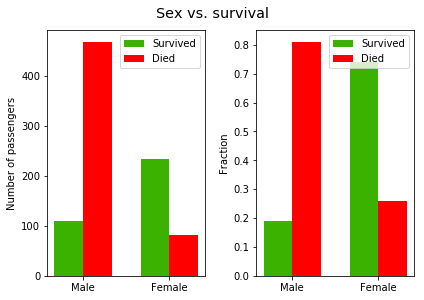

In [0]:
# Split the survived and died data between male and female
survived_male_data = survived_data.loc[survived_data['Sex']=='male',:]
died_male_data = died_data.loc[died_data['Sex']=='male',:]
survived_female_data = survived_data.loc[survived_data['Sex']=='female',:]
died_female_data = died_data.loc[died_data['Sex']=='female',:]

# Total number of (fe)males that survived and that died
survived_male_n = survived_male_data.shape[0]
died_male_n = died_male_data.shape[0]
survived_female_n = survived_female_data.shape[0]
died_female_n = died_female_data.shape[0]

import matplotlib.pyplot as pp

# Bar plot drawing
fig, axes = pp.subplots(nrows=1, ncols=2)

# Sex vs. survival in total numbers
pp.axes(axes[0])
survived = pp.bar([0.5, 3.5], [survived_male_n, survived_female_n], width=1, 
       color='#3BB200')
died = pp.bar([1.5, 4.5], [died_male_n, died_female_n], width=1, 
       color='red')
pp.xticks([1,4], ('Male', 'Female'))
pp.ylabel('Number of passengers')
pp.legend((survived, died), ('Survived', 'Died'), loc=0, fontsize = 'medium')

# Sex vs. survival in fractions
pp.axes(axes[1])
survived_pct = pp.bar([0.5, 3.5], [survived_male_n/(survived_male_n+died_male_n), 
                               survived_female_n/(survived_female_n+died_female_n)], 
                      width=1, color='#3BB200')
died_pct = pp.bar([1.5, 4.5], [died_male_n/(survived_male_n+died_male_n), 
                           died_female_n/(survived_female_n+died_female_n)], 
                  width=1, color='red')
pp.xticks([1,4], ('Male', 'Female'))
pp.ylabel('Fraction')
pp.legend((survived, died), ('Survived', 'Died'), fontsize = 'medium')
fig.suptitle('Sex vs. survival', fontsize = 'x-large', y=1.03)
pp.tight_layout()
pp.show()

We can see that in absolute numbers there are far more male passengers than female passengers in the training data, and the survival odds of males are much lower than those of females. 

Now, let's take a look at the effects of age on survival. The 'Age' column of our DataFrame contains NaN values, which will have to be filtered out in order to create the histogram. This means that the following plots will be based on only the 714 non-NaN values in the 'Age' column. Because we will have to remove passengers with NaN values more often, we will define a function checkNans that will help us do this: 

In [0]:
def checkNans(arr, arr2=None):
    mask_nan = pd.isnull(arr) # using pandas isnull to also operate
                              # on string fields
    if mask_nan.sum()>0:
        any_nan = True
    else:
        any_nan = False
    n_nan = mask_nan.sum()
    
    masked_arr = arr[~mask_nan]
    if arr2 is not None:
        masked_arr2 = arr2[~mask_nan]
    else: 
        masked_arr2 = None

    return any_nan, masked_arr, masked_arr2, n_nan, mask_nan

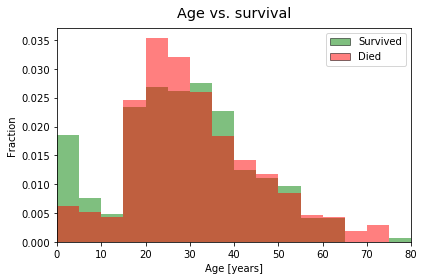

In [0]:
# Extract age data of the survived and died passengers,
# check for nans
survived_age = checkNans(survived_data['Age'])[1]
died_age = checkNans(died_data['Age'])[1]

# Histogram
# Determine bin edges of the combined data so that you can use these in 
# the final histogram, in order to make sure that the histogram bin 
# widths are equal for both groups
stacked = np.hstack((survived_age, died_age))
bins = np.histogram(stacked, bins=16, range=(0,stacked.max()))[1] 

# Creating the histograms
survived = pp.hist(survived_age, bins, normed=1, facecolor='green', 
                   alpha=0.5)
died = pp.hist(died_age, bins, normed=1, facecolor='red', alpha=0.5)

# Create custom handles for adding a legend to the histogram
import matplotlib.patches as mpatches
survived_handle = mpatches.Patch(facecolor='green', alpha=0.5, 
                                label='Survived', edgecolor='black')
died_handle = mpatches.Patch(facecolor='red', alpha=0.5, label='Died', 
                                edgecolor='black')
pp.legend((survived_handle, died_handle), ('Survived', 'Died'), loc=0, 
                                fontsize = 'medium')

# Other plot settings
pp.title('Age vs. survival', fontsize = 'x-large', y=1.02)
pp.xlabel('Age [years]')
pp.ylabel('Fraction')
pp.xlim([0,stacked.max()])
pp.tight_layout()
pp.show()

So what we can see here is that the age distributions of those who survived and those who died are quite similar. Passengers older than ~65 seem to have worse odds of surviving, and children aged below ~16 seem to have better odds of surviving, but overall the effects are not too great. It would be interesting to replicate this for males and females separately, which is what we'll do next.

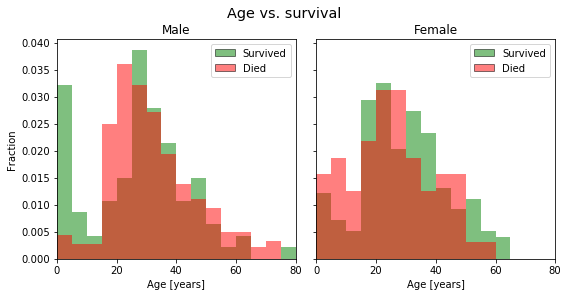

In [0]:
# Extract age data of the survived and died passengers for males 
# and females separately, check for nans
survived_male_age = checkNans(survived_male_data['Age'])[1]
died_male_age = checkNans(died_male_data['Age'])[1]
survived_female_age = checkNans(survived_female_data['Age'])[1]
died_female_age = checkNans(died_female_data['Age'])[1]

# Histogram
# Create subplots with shared y-axis
fig, axes = pp.subplots(nrows=1, ncols=2, figsize=(8,4), sharey=True)

# Creating the histograms
# For the bin edges, we can use the same as bin edges as in the 
# previous plot
# Male histogram
pp.axes(axes[0])
survived_male = pp.hist(survived_male_age, bins, normed=1, 
                        facecolor='green', alpha=0.5)
died_male = pp.hist(died_male_age, bins, normed=1, facecolor='red', 
                        alpha=0.5)
pp.legend((survived_handle, died_handle), ('Survived', 'Died'),
          loc=0, fontsize = 'medium') # Using the same legend handles 
                                      # as before
pp.title('Male')
pp.xlabel('Age [years]')
pp.ylabel('Fraction')
pp.xlim([0,stacked.max()]) # Using the same range as in the previous plot
pp.tight_layout()

# Female histogram
pp.axes(axes[1])
survived_female = pp.hist(survived_female_age, bins, normed=1, 
                          facecolor='green', alpha=0.5)
died_female = pp.hist(died_female_age, bins, normed=1, facecolor='red', 
                      alpha=0.5)
pp.legend((survived_handle, died_handle), ('Survived', 'Died'), loc=0, 
          fontsize = 'medium') # Using the same legend handles as before
pp.title('Female')
pp.xlabel('Age [years]')
pp.xlim([0,stacked.max()]) # Using the same range as in the previous plot
pp.tight_layout()
fig.suptitle('Age vs. survival', fontsize = 'x-large', y=1.02)
pp.show()

The added differentation between male and female does not provide any real insights except that for really young (<10 years) male childs the odds of surviving are much higher than for girls of the same age. This could be a statistical glitch if the number of boys aged <10 is much different from the number of girls aged <10, or if both groups are very small in size. However, both groups have 19 members.

In [0]:
print('Number of males aged <10: {}'.format\
      (survived_male_age[survived_male_age<10].count()))
print('Number of females aged <10: {}'.format\
      (survived_female_age[survived_female_age<10].count()))

Number of males aged <10: 19
Number of females aged <10: 19


Ticket class and ticket fare most likely will somewhat move together. Let's make some boxplots to verify this.

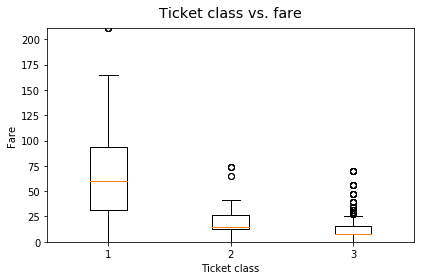

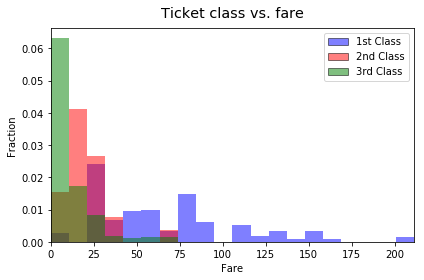

In [0]:
# Extract the ticket fares for the various ticket classes
fare_1 = train_data['Fare'].loc[train_data['Pclass']==1]
fare_2 = train_data['Fare'].loc[train_data['Pclass']==2]
fare_3 = train_data['Fare'].loc[train_data['Pclass']==3]

# Boxplots
pp.boxplot([fare_1, fare_2, fare_3])
pp.ylim((0,train_data['Fare'].quantile(0.98))) 
# Only the lowest 98% of fares are shown because 
# otherwise the boxes would be hard to compare visually

# Plot settings
pp.ylabel('Fare')
pp.xlabel('Ticket class')
pp.title('Ticket class vs. fare', fontsize = 'x-large', y=1.02)
pp.tight_layout()
pp.show()

# Histogram
# Determine bin edges of the combined data so that you can use 
# these in the final histogram, in order to make sure that the 
# histogram bin widths are equal for all three classes
bins = np.histogram(train_data['Fare'].loc[train_data['Fare']
        <(train_data['Fare'].quantile(0.98))], bins=20, 
        range=(0,train_data['Fare'].loc[train_data['Fare']<
        (train_data['Fare'].quantile(0.98))].max()))[1] 

# Creating the histograms
class_1 = pp.hist(fare_1, bins, normed=1, facecolor='blue', alpha=0.5)
class_2 = pp.hist(fare_2, bins, normed=1, facecolor='red', alpha=0.5)
class_3 = pp.hist(fare_3, bins, normed=1, facecolor='green', alpha=0.5)

# Create custom handles for adding a legend to the histogram
class_1_handle = mpatches.Patch(facecolor='blue', alpha=0.5, 
                                label='Class 1', edgecolor='black')
class_2_handle = mpatches.Patch(facecolor='red', alpha=0.5, 
                                label='Class 2', edgecolor='black')
class_3_handle = mpatches.Patch(facecolor='green', alpha=0.5, 
                                label='Class 3', edgecolor='black')

pp.legend((class_1_handle, class_2_handle, class_3_handle), 
          ('1st Class', '2nd Class', '3rd Class'), 
          loc=0, fontsize = 'medium')

# Plot settings
pp.title('Ticket class vs. fare', fontsize = 'x-large', y=1.02)
pp.xlabel('Fare')
pp.ylabel('Fraction')
pp.xlim((0,train_data['Fare'].quantile(0.98)))
pp.tight_layout()
pp.show()

So the classes somewhat overlap, although the histogram does not visualize this very clearly. Let's look at the effect of ticket class on survival.

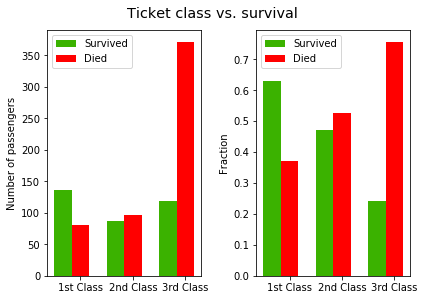

In [0]:
# Extract the survival data for the various ticket classes
survived_class_1 = survived_data['Survived'].loc[survived_data['Pclass']==1]
died_class_1 = died_data['Survived'].loc[died_data['Pclass']==1]
survived_class_2 = survived_data['Survived'].loc[survived_data['Pclass']==2]
died_class_2 = died_data['Survived'].loc[died_data['Pclass']==2]
survived_class_3 = survived_data['Survived'].loc[survived_data['Pclass']==3]
died_class_3 = died_data['Survived'].loc[died_data['Pclass']==3]

# Total number of passengers from each class that survived and that died
survived_class_1_n = survived_class_1.shape[0]
died_class_1_n = died_class_1.shape[0]
survived_class_2_n = survived_class_2.shape[0]
died_class_2_n = died_class_2.shape[0]
survived_class_3_n = survived_class_3.shape[0]
died_class_3_n = died_class_3.shape[0]

# Bar plot drawing
fig, axes = pp.subplots(nrows=1, ncols=2)

# Ticket class vs. survival in total numbers
pp.axes(axes[0])
survived = pp.bar([0.5, 3.5, 6.5], [survived_class_1_n, survived_class_2_n,
                                    survived_class_3_n], width=1, 
                                    color='#3BB200')
died = pp.bar([1.5, 4.5, 7.5], [died_class_1_n, died_class_2_n, 
                                died_class_3_n], width=1, color='red')
pp.xticks([1.5,4.5,7.5], ('1st Class', '2nd Class', '3rd Class'))

pp.ylabel('Number of passengers')
pp.legend((survived, died), ('Survived', 'Died'), loc=0, 
          fontsize = 'medium')

# Sex vs. survival in fractions
pp.axes(axes[1])
survived_pct = pp.bar([0.5, 3.5, 6.5], [survived_class_1_n/(survived_class_1_n + 
                                                            died_class_1_n), 
                                        survived_class_2_n/(survived_class_2_n + 
                                                            died_class_2_n),
                                         survived_class_3_n/(survived_class_3_n + 
                                                            died_class_3_n)], 
                      width=1, color='#3BB200')
died_pct = pp.bar([1.5, 4.5, 7.5], [died_class_1_n/(survived_class_1_n + 
                                                            died_class_1_n), 
                                        died_class_2_n/(survived_class_2_n + 
                                                            died_class_2_n),
                                         died_class_3_n/(survived_class_3_n + 
                                                            died_class_3_n)],  
                  width=1, color='red')
pp.xticks([1.5,4.5,7.5], ('1st Class', '2nd Class', '3rd Class'))
#pp.xlim([0,8])
pp.ylabel('Fraction')
leg = pp.legend((survived, died), ('Survived', 'Died'), 
                fontsize = 'medium', loc='upper left')
fig.suptitle('Ticket class vs. survival', fontsize = 'x-large', y=1.03)
pp.tight_layout()
pp.show()

We observe that passengers with a total of 3 or more siblings+spouse aboard the Titanic are far more likely to die than to survive (3rd plot). However, in absolute numbers (1st plot), this group is small. There were no passengers in our training set with 6 or 7 siblings+spouse aboard the Titanic, which explains the absence of bars for these categories, and which could produce some RuntimeWarnings. 

On to the effect of number of parents+children on survival. Here we observe that those passengers without any parents or children on board, and those with 4 or more parents or children on board, are more likely to die in the incident than to survive (4th plot). There were only a few passengers with 3 or more parents or children on board (2nd plot).

So it seems that 1st class passengers had better odds of survival, and 3rd class passengers had far worse odds. 2nd Class passengers were about equally likely to either survive or die. 

The next thing that we'll look at is the number of siblings+spouse vs. survival and the number of parents+children vs. survival. The feature is discrete and numerical; we will therefore bin the data in bins of width 1 and create a histogram like above. The 'SibSp' and 'Parch' columns of our data do not contain any NaN values so we do not need to preprocess them. 

Fraction of total survived / died passengers 
accounted for by a certain bin


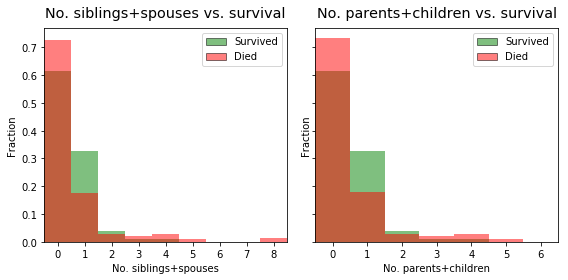

Fraction of survived / died passengers within a certain bin


/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:86: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:90: RuntimeWarning: invalid value encountered in true_divide


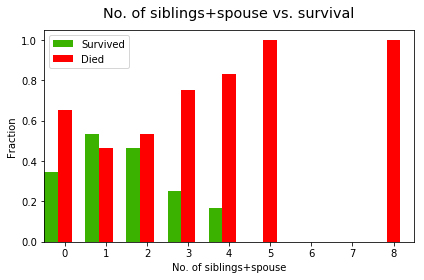

Fraction of survived / died passengers within a certain bin


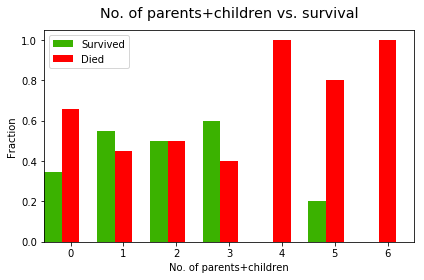

In [0]:
fig, axes = pp.subplots(nrows=1, ncols=2, figsize=(8,4), sharey=True)

# SIBSP
pp.axes(axes[0])
# Extract SibSp data of the survived and died passengers
survived_sibsp = survived_data['SibSp']
died_sibsp = died_data['SibSp']

# Histogram
# Determine bin edges of the combined data so that you can use 
# these in the final histogram, in order to make sure that the 
# histogram bin widths are equal for both groups
stacked = np.hstack((survived_sibsp, died_sibsp))
bins = np.histogram(stacked, bins=stacked.max()+1, range=
                    (0,stacked.max()+1))[1] 
# The number of bins = stacked.max() so that each bin is of width 1

# Creating the histograms
survived = pp.hist(survived_sibsp, bins, normed=1, facecolor='green', 
                   alpha=0.5)
died = pp.hist(died_sibsp, bins, normed=1, facecolor='red', alpha=0.5)

# Plot settings
pp.legend((survived_handle, died_handle), ('Survived', 'Died'), loc=0, 
          fontsize = 'medium') # Using the same legend handles as before
pp.title('No. siblings+spouses vs. survival', fontsize = 'x-large', y=1.02)
pp.xlabel('No. siblings+spouses')
pp.ylabel('Fraction')
pp.xticks(np.arange(train_data['SibSp'].max()+1)+0.5, 
          np.arange(train_data['SibSp'].max()+1))
pp.xlim([0,stacked.max()+1])
pp.tight_layout()

# PARCH
pp.axes(axes[1])
# Extract Parch data of the survived and died passengers
survived_parch = survived_data['Parch']
died_parch = died_data['Parch']

# Histogram
# Determine bin edges of the combined data so that you can use 
# these in the final histogram, in order to make sure that the 
# histogram bin widths are equal for both groups
stacked = np.hstack((survived_parch, died_parch))
bins = np.histogram(stacked, bins=stacked.max(), 
                    range=(0,stacked.max()))[1] 
    # The number of bins = stacked.max() so that each bin is of width 1

# Creating the histograms
survived = pp.hist(survived_sibsp, bins, normed=1, facecolor='green', 
                   alpha=0.5)
died = pp.hist(died_sibsp, bins, normed=1, facecolor='red', alpha=0.5)

# Plot settings
pp.legend((survived_handle, died_handle), ('Survived', 'Died'), loc=0, 
          fontsize = 'medium') # Using the same legend handles as before
pp.title('No. parents+children vs. survival', fontsize = 'x-large', y=1.02)
pp.xlabel('No. parents+children')
pp.xticks(np.arange(train_data['Parch'].max()+1)+0.5, 
          np.arange(train_data['Parch'].max()+1))
pp.ylabel('Fraction')
pp.xlim([0,stacked.max()+1])
pp.tight_layout()

print('Fraction of total survived / died passengers \n\
accounted for by a certain bin')
pp.show()

# SIBSP
## The same as above, but now with the fractions within each category:
# Extract the survival data for the various SibSp classes
sibsp_classes = np.arange(train_data['SibSp'].max() + 1)
sibsp_data = {'survived_n':np.array([]), 'survived_pct':np.array([]), 
              'died_n':np.array([]), 'died_pct':np.array([])}
for ii in sibsp_classes:
    sibsp_data['survived_'+str(ii)] = survived_data['Survived'].loc[
        survived_data['SibSp']==ii]
    sibsp_data['survived_n'] = np.append(sibsp_data['survived_n'],
        np.array((sibsp_data['survived_'+str(ii)].count())))
    sibsp_data['died_'+str(ii)] = died_data['Survived'].loc[
        died_data['SibSp']==ii]
    sibsp_data['died_n'] = np.append(sibsp_data['died_n'],
        np.array((sibsp_data['died_'+str(ii)].count())))

sibsp_data['survived_pct'] = (sibsp_data['survived_n']/  
                                              (sibsp_data['survived_n']+
                                               sibsp_data['died_n']))
sibsp_data['survived_pct'][np.isnan(sibsp_data['survived_pct'])]=0
sibsp_data['died_pct'] = (sibsp_data['died_n']/  
                                              (sibsp_data['survived_n']+
                                               sibsp_data['died_n']))
sibsp_data['died_pct'][np.isnan(sibsp_data['died_pct'])]=0

# No. of siblings+spouses vs. survival in fractions

survived_pct = pp.bar(np.arange(train_data['SibSp'].max()+1)*3+0.5, 
                      sibsp_data['survived_pct'], width=1, color='#3BB200')
died_pct = pp.bar(np.arange(train_data['SibSp'].max()+1)*3+1.5, 
                      sibsp_data['died_pct'], width=1, color='red')
pp.xticks(np.arange(train_data['SibSp'].max()+1)*3+1.5, 
          np.arange(train_data['SibSp'].max()+1))
pp.xlim([0,(train_data['SibSp'].max()+1)*3])
pp.xlabel('No. of siblings+spouse')
pp.ylabel('Fraction')
leg = pp.legend((survived_pct, died_pct), ('Survived', 'Died'), 
                fontsize = 'medium', loc='upper left')
pp.title('No. of siblings+spouse vs. survival', fontsize = 
         'x-large', y=1.03)
pp.tight_layout()
print('Fraction of survived / died passengers within a certain bin')
pp.show()

# PARCH
# Extract ParCh data of the survived and died passengers
survived_parch = survived_data['Parch']
died_parch = died_data['Parch']

# Extract the survival data for the various ParCh classes
parch_classes = np.arange(train_data['Parch'].max() + 1)
parch_data = {'survived_n':np.array([]), 'survived_pct':np.array([]), 
              'died_n':np.array([]), 'died_pct':np.array([])}
for ii in parch_classes:
    parch_data['survived_'+str(ii)] = survived_data['Survived'].loc[
        survived_data['Parch']==ii]
    parch_data['survived_n'] = np.append(parch_data['survived_n'],
        np.array((parch_data['survived_'+str(ii)].count())))
    parch_data['died_'+str(ii)] = died_data['Survived'].loc[
        died_data['Parch']==ii]
    parch_data['died_n'] = np.append(parch_data['died_n'],
        np.array((parch_data['died_'+str(ii)].count())))

parch_data['survived_pct'] = (parch_data['survived_n']/  
                                              (parch_data['survived_n']+
                                               parch_data['died_n']))
parch_data['survived_pct'][np.isnan(parch_data['survived_pct'])]=0
parch_data['died_pct'] = (parch_data['died_n']/  
                                              (parch_data['survived_n']+
                                               parch_data['died_n']))
parch_data['died_pct'][np.isnan(parch_data['died_pct'])]=0

# No. of parents+children vs. survival in fractions
survived_pct = pp.bar(np.arange(train_data['Parch'].max()+1)*3+0.5, 
                      parch_data['survived_pct'], width=1, color='#3BB200')
died_pct = pp.bar(np.arange(train_data['Parch'].max()+1)*3+1.5, 
                      parch_data['died_pct'], width=1, color='red')
pp.xticks(np.arange(train_data['Parch'].max()+1)*3+1.5, 
          np.arange(train_data['Parch'].max()+1))
pp.xlim([0,(train_data['Parch'].max()+1)*3])
pp.xlabel('No. of parents+children')
pp.ylabel('Fraction')
leg = pp.legend((survived_pct, died_pct), ('Survived', 'Died'), 
                fontsize = 'medium', loc='upper left')
pp.title('No. of parents+children vs. survival', fontsize = 'x-large', 
         y = 1.03)
pp.tight_layout()
print('Fraction of survived / died passengers within a certain bin')
pp.show()

We have already seen that the ticket fares for the three ticket classes do overlap, and that the ticket class has predictive power on survival odds. When we group the ticket fares into bins, we can show the survival odds for each bin. Below I have grouped the data in bins of width=10; above a ticket fare of 250 only a few data points exist, and these have been grouped together. 

In [0]:
bins = np.append(np.arange(0,251,10), train_data['Fare'].max())
train_fare_binned = pd.cut(train_data['Fare'], bins, include_lowest=True)
train_data[['Survived']].groupby(train_fare_binned).mean()

print('Number of passengers:\n{}'.format(train_data[
    'Fare'].groupby(train_fare_binned).count()))
print('\n')
print('Average survival:\n{}'.format(train_data[
    'Survived'].groupby(train_fare_binned).mean()))

Number of passengers:
Fare
[0, 10]           336
(10, 20]          179
(20, 30]          142
(30, 40]           58
(40, 50]           16
(50, 60]           38
(60, 70]           17
(70, 80]           31
(80, 90]           17
(90, 100]           4
(100, 110]          4
(110, 120]         11
(120, 130]          0
(130, 140]          7
(140, 150]          2
(150, 160]          7
(160, 170]          2
(170, 180]          0
(180, 190]          0
(190, 200]          0
(200, 210]          0
(210, 220]          4
(220, 230]          5
(230, 240]          0
(240, 250]          2
(250, 512.329]      9
Name: Fare, dtype: int64


Average survival:
Fare
[0, 10]           0.199405
(10, 20]          0.424581
(20, 30]          0.443662
(30, 40]          0.396552
(40, 50]          0.250000
(50, 60]          0.710526
(60, 70]          0.352941
(70, 80]          0.612903
(80, 90]          0.823529
(90, 100]         1.000000
(100, 110]        0.500000
(110, 120]        0.818182
(120, 130]             NaN


We observe that passengers in the lowest fare category are very numerous and also have very bad survival odds. We further notice that the next two most-populous groups have better survival odds than for our training set as a whole (38.4%).

Lastly, the average survival rates for the various categories in the 'Embarked', 'Cabin_cat' and 'Title' features will be presented. 

In [0]:
print('Average survival:\n{}'.format(train_data[['Embarked',
    'Survived']].groupby('Embarked').mean()))
print('\n')
print('{}'.format(train_data[['Cabin_cat',
    'Survived']].groupby('Cabin_cat').mean()))
print('\n')
print('{}'.format(train_data[['Title',
    'Survived']].groupby('Title').mean()))

Average survival:
          Survived
Embarked          
C         0.553571
Q         0.389610
S         0.336957


           Survived
Cabin_cat          
A          0.466667
B          0.744681
C          0.593220
D          0.757576
E          0.750000
F          0.615385
G          0.500000
None       0.299854
T          0.000000


         Survived
Title            
Army.    0.400000
Dr.      0.428571
Master.  0.575000
Miss.    0.702703
Mr.      0.156673
Mrs.     0.793651
Noble.   0.600000
Rev.     0.000000


There seems to be enough distribution within those features for them to be relevant to our classification problem, so they will be included.

We have seen some trends in the data. If we assume independence of the examined features, a man aged 20-25, travelling 3rd class, with a total of 5 siblings + spouse, and 4 parents + children, boarded in Southampton, would have far worse odds of surviving than a married woman aged 35-40, travelling 1st class, with 1 sibling or spouse, and 3 parents + children, boarded in Cherbourg. 

This concludes the Exploratory Data Analysis that we will be doing. We will now focus on training machine learning models on the data. 

### Preprocessing for machine learning
Here we will apply some preprocessing that is needed in particular for various machine learning algorithms to efficiently operate on the data. We will start by encoding our categorical features ('Sex', 'Embarked', 'Title' and 'Cabin_cat') in a numerical format. We will use sklearn.preprocessing.OneHotEncoder for this; however, OneHotEncoder only works with *numerical* categorical data. We will use sklearn.preprocessing.LabelEncoder to encode our string labels with numbers.

The features that we are going to encode might contain missing values/NaNs/Nones. These will have to be imputed. I am not imputing all features in this stage because for the imputation I want to find the *K* nearest neighbors of a sample that needs imputation (based on its other features), and finding these *K* neigbors will be more accurate once the categorical features are One-Hot labeled. First let's see which of our categories features NaN/None values.

In [0]:
train_data[['Sex','Embarked','Title','Cabin_cat']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 4 columns):
Sex          891 non-null object
Embarked     889 non-null object
Title        891 non-null object
Cabin_cat    891 non-null object
dtypes: object(4)
memory usage: 34.8+ KB


So only the 'Embarked' feature contains null entries, 2 in total. Let's find those entries:

In [0]:
train_data.loc[pd.isnull(train_data['Embarked'])]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Cabin_cat
PassengerId,,,,,,,,,,
62,1,1,female,38.0,0,0,80.0,NaN,Miss.,B
830,1,1,female,62.0,0,0,80.0,NaN,Mrs.,B


The passengers with PassengerId 62 and 830 do not have a known port of embarkation. We will come back to the imputation of those values later; first, lets One-Hot label the other features, so that we can do a more accurate imputation later on. 

In [0]:
from sklearn.preprocessing import LabelEncoder

# Converting to numerical features
# Sex feature
le_sex = LabelEncoder()
sex_numerical = le_sex.fit_transform(train_data['Sex'])
sex_numerical_classes = le_sex.classes_

# Title feature
le_title = LabelEncoder()
title_numerical = le_title.fit_transform(train_data['Title'])
title_numerical_classes = le_title.classes_

# Cabin_cat feature
le_cabin_cat = LabelEncoder()
cabin_cat_numerical = le_cabin_cat.fit_transform(train_data['Cabin_cat'])
cabin_cat_numerical_classes = le_cabin_cat.classes_

print('Classes of Sex feature:\n{}\n{}'.format(
        np.arange(len(sex_numerical_classes)), sex_numerical_classes))
print('')
print('Classes of Title feature:\n{}\n{}'.format(
        np.arange(len(title_numerical_classes)), title_numerical_classes))
print('')
print('Classes of Cabin_cat feature:\n{}\n{}'.format(
        np.arange(len(cabin_cat_numerical_classes)), cabin_cat_numerical_classes))

Classes of Sex feature:
[0 1]
['female' 'male']

Classes of Title feature:
[0 1 2 3 4 5 6 7]
['Army.' 'Dr.' 'Master.' 'Miss.' 'Mr.' 'Mrs.' 'Noble.' 'Rev.']

Classes of Cabin_cat feature:
[0 1 2 3 4 5 6 7 8]
['A' 'B' 'C' 'D' 'E' 'F' 'G' 'None' 'T']


We will create One-Hot labeled features:

In [0]:
from sklearn.preprocessing import OneHotEncoder
# Sex feature
enc_sex = OneHotEncoder(sparse=False)
sex_onehot = enc_sex.fit_transform(sex_numerical.reshape(-1,1))

# Title feature
enc_title = OneHotEncoder(sparse=False)
title_onehot = enc_title.fit_transform(title_numerical.reshape(-1,1))

# Cabin_cat feature
enc_cabin_cat = OneHotEncoder(sparse=False)
cabin_cat_onehot = enc_cabin_cat.fit_transform(cabin_cat_numerical.reshape(-1,1))

Drop the original categorical features and add the one-hot labeled features. Map names to the new features based on the classes printed above, using a new function pdAssignWithOHLabel():

In [0]:
def pdAssignWithOHLabel(df, column, onehot_labeled, class_labels):
    to_assign = {}
    for c_idx, label in enumerate(class_labels):
        to_assign[column+'_'+label] = onehot_labeled[:,c_idx]
    df = df.assign(**to_assign)
    return df

In [0]:
# Sex feature
train_data = pdAssignWithOHLabel(train_data, 'Sex', 
                                 sex_onehot, sex_numerical_classes)
train_data = train_data.drop('Sex',axis=1)

# Title feature
train_data = pdAssignWithOHLabel(train_data, 'Title', 
                                 title_onehot, title_numerical_classes)
train_data = train_data.drop('Title',axis=1)

# Cabin_cat feature
train_data = pdAssignWithOHLabel(train_data, 'Cabin_cat', 
                            cabin_cat_onehot, cabin_cat_numerical_classes)
train_data = train_data.drop('Cabin_cat',axis=1)

train_data.head(0)

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Sex_female,Sex_male,Title_Army.,...,Title_Rev.,Cabin_cat_A,Cabin_cat_B,Cabin_cat_C,Cabin_cat_D,Cabin_cat_E,Cabin_cat_F,Cabin_cat_G,Cabin_cat_None,Cabin_cat_T
PassengerId,,,,,,,,,,,,,,,,,,,,,


The 'Embarked' data has not been imputed or Hot-One labeled yet. We will perform imputation based on the 5 nearest neighbors of a passenger; accurate nearest neighbor finding requires our features to be scaled. sklearn.preprocessing.StandardScaler() will be used to scale the features; however, StandardScaler does not provide good results when the data contains outliers. We recall the ticket fare box plot from the Exploratory Data Analysis section; only the smallest 98% of the data was shown in that plot, because there were some far-outlying points. We plot the ticket fare data again:

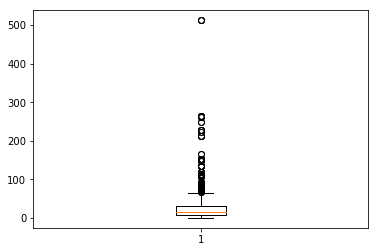

In [0]:
pp.boxplot([train_data['Fare']]) 
pp.show()

Data points that lie outside a range of mean + 3\* standard deviation or even farther away can certainly bring meaningul information to our models; however, in case of the 'Fare' feature, there are 3 data points that unproportionally influence the results of the StandardScaler because they lie so far apart from the other values. Let's set their values to the mean+5\* standard deviation of the ticket fares:

In [0]:
mu = train_data['Fare'].mean()
sd = train_data['Fare'].std()

row_mask = train_data['Fare']>mu+5*sd
train_data.set_value(row_mask, 'Fare', mu+5*sd);

Now we can perform standard scaling on all features except the 'Embarked' and 'Age' feature, because both need to be imputed. This scaling will be performed on a temporary copy of the training data because with the sole purpose of being able to more accurately find nearest neighbors for data imputation. Persistent scaling will be performed on the training data in the ML fitting section. Also, the 'Survived' feature does not need scaling since it will be our target label in the ML model training:

In [0]:
from sklearn.preprocessing import StandardScaler
sc_tmp = StandardScaler()
tmp_scaled = train_data.copy().drop(['Embarked','Age','Survived'], axis=1) # create a copy of the data
tmp_scaled = pd.DataFrame(sc_tmp.fit_transform(tmp_scaled),columns=tmp_scaled.columns, index=tmp_scaled.index)

# Add the non-scaled features to this temporary DataFrame
tmp_scaled = tmp_scaled.assign(Survived=train_data['Survived'])
tmp_scaled = tmp_scaled.assign(Embarked=train_data['Embarked'])
tmp_scaled = tmp_scaled.assign(Age=train_data['Age'])

We found before that passengers 62 and 830 did not have non-null values for the 'Embarked' feature. Here, let's find the 5 nearest neighbors of these passengers based on all features except 'Age', 'Embarked' and 'Survived', and assign a value for 'Embarked' based on the average value of their nearest neighbors on that feature:

In [0]:
from sklearn.neighbors import KDTree
tmp = tmp_scaled.copy().drop(['Survived','Age','Embarked'], axis=1).values
row_idx = pd.isnull(train_data['Embarked'])
tree = KDTree(tmp)
dist, ind = tree.query(tmp[[62, 830]], k=6) 
# The k nearest neighbors include the passenger itself, 
# so we specify k=6 to get the 5 nearest neighbors
for i in ind:
    print('5 closest neigbors to passenger {} and their values for Embarked:\n{}\n'\
          .format(i[0], train_data['Embarked'].loc[i[1:]]))

5 closest neigbors to passenger 62 and their values for Embarked:
PassengerId
741    S
453    C
224    S
336    S
544    S
Name: Embarked, dtype: object

5 closest neigbors to passenger 830 and their values for Embarked:
PassengerId
578    S
132    S
186    S
142    S
347    S
Name: Embarked, dtype: object



Based on the above, both passengers will be assigned an 'S' in the 'Embarked' feature:

In [0]:
train_data.set_value([62, 830], 'Embarked', 'S');

The 'Embarked' feature is now also ready to be One-Hot labeled:

In [0]:
# Encode the values with numerical labels
le_embarked = LabelEncoder()
embarked_numerical = le_embarked.fit_transform(train_data['Embarked'])
embarked_numerical_classes = le_embarked.classes_
print('Classes of Embarked feature:\n{}\n{}'.format(
        np.arange(len(embarked_numerical_classes)), 
        embarked_numerical_classes))

# One-Hot encoding
enc_embarked = OneHotEncoder(sparse=False)
embarked_onehot = enc_embarked.fit_transform(embarked_numerical.reshape(-1,1))

# Add new features
train_data = pdAssignWithOHLabel(train_data, 'Embarked', embarked_onehot, 
                                 embarked_numerical_classes)
tmp_scaled = pdAssignWithOHLabel(tmp_scaled, 'Embarked', embarked_onehot, 
                                 embarked_numerical_classes)
# Drop old feature
train_data = train_data.drop('Embarked',axis=1)
tmp_scaled = tmp_scaled.drop('Embarked',axis=1)

Classes of Embarked feature:
[0 1 2]
['C' 'Q' 'S']


The new columns need to be standard-scaled:

In [0]:
sc_tmp = StandardScaler()
tmp = tmp_scaled[['Embarked_C', 'Embarked_Q', 'Embarked_S']].copy()
tmp = pd.DataFrame(sc_tmp.fit_transform(tmp),columns=tmp.columns, index=tmp.index)

# Drop the unscaled features from train_data 
tmp_scaled = tmp_scaled.drop(['Embarked_C', 'Embarked_Q', 'Embarked_S'], 
                             axis=1)

# Assign the scaled features to train_data
tmp_scaled = tmp_scaled.assign(Embarked_C=tmp['Embarked_C'])
tmp_scaled = tmp_scaled.assign(Embarked_Q=tmp['Embarked_Q'])
tmp_scaled = tmp_scaled.assign(Embarked_S=tmp['Embarked_S'])

We still need to work on feature 'Age' which has null entries and is not scaled yet. As above, we will impute this feature based on nearest neighbors' values. Because the 'Age' column contains quite some null values, we will use 7 nearest neighbors instead of 5. 

In [0]:
def knnImpute(ori_arr, tmp_imp_arr, feature, k=6): # improved one
    from sklearn.neighbors import KDTree
    row_idx = ori_arr[pd.isnull(ori_arr[feature])].index.tolist()
    tree = KDTree(tmp_imp_arr) # tmp_arr is the array without 
                           # the null-containing feature
    #row_idx = np.add(row_idx, -1)
    for nan_v in row_idx:
        # Uncomment print statements below to get some more insight
        #print('Passenger: {}'.format(nan_v))
        dist, ind = tree.query(tmp_imp_arr[nan_v,:].reshape(1,-1), k)
        #print(tmp_arr[nan_v,:])
        #print(ind[0])
        nn_vals = ori_arr[feature].loc[ind[0][1:]]
        imp_val = np.floor(np.nanmean(nn_vals))+0.5 
        # Per the documentation on this Kaggle data set, estimated
        # 'Age' values are of the form x.5
        
        #print('{} closest neigbors to passenger {} and their values for ' \
        #'Age:\n{}\n'.format(k-1, nan_v, ori_arr[feature].loc[ind[0]]))
        #print('Imputed value would be {}\n'.format(imp_val))
        ori_arr.set_value(nan_v, feature, imp_val)
    return ori_arr

In [0]:
tmp_imp = tmp_scaled.copy().drop('Age', axis = 1).values
train_data = knnImpute(train_data, tmp_imp, 'Age', 8)
print('New number of null values in "Age" column: {}'.format(
    pd.isnull(train_data['Age']).sum()))

New number of null values in "Age" column: 0


Now that all the data has been imputed, let's visualize a PCA plot on the first two principal components of the data to see if the data is easily separated:

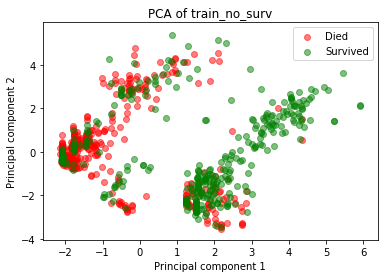

In [0]:
from sklearn.decomposition import PCA
# First scale the data
sc_training = StandardScaler()
tmp = train_data.copy().drop(['Survived'], axis=1).values # create a copy of the data
sc_training = sc_training.fit(tmp)

train_no_surv = train_data.copy().drop('Survived', axis=1)
train_no_surv = sc_training.transform(train_no_surv)
pca = PCA()
pca.fit(train_no_surv)
t = pca.transform(train_no_surv)

died = t[np.array(train_data['Survived']==0), :]
survived = t[np.array(train_data['Survived']==1), :]
components = [0, 1] # Which principal components to plot against

pp.scatter(died[:,components[0]].reshape(1,-1), died[:,components[1]].reshape(1,-1), 
           color='red', alpha=.5, label='Died')
pp.scatter(survived[:,components[0]].reshape(1,-1), survived[:,components[1]].reshape(1,-1), 
           color='Green', alpha=.5, label='Survived')

pp.legend(loc='best', shadow=False, scatterpoints=1)
pp.title('PCA of train_no_surv')
pp.xlabel('Principal component {}'.format(components[0]+1))
pp.ylabel('Principal component {}'.format(components[1]+1))
pp.show()

We observe that in the PC1, PC2 space some clustering of the data seems to take place; however, the two groups ('Died' and 'Survived') do overlap in this space. 

Now that the all features that required it have been imputed and a StandardScaler has been trained for later usage, we are ready to begin fitting our machine learning models:

### Fitting machine learning models
Now that our data has been extensively preprocessed we will (finally!) be training various machine learning models on our data. In the following steps, the training data will be split (using cross-validation) into training and test data sets. ML models and StandardScalers will be trained on the training subsets and subsequently be applied to the test subset.   of Scaling of the final (as of yet unknown) test data will have to be performed using the same StandardScaler that will be used to transform the training data. Since scaling in the previous steps took place inside cross-validations, we'll fit a StandardScaler on the entire training data here, so that it can be used in scaling test data:

In [0]:
# Extract training data (without Survived feature) and class labels
columns = ['Age', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male',
       'Title_Army.', 'Title_Dr.', 'Title_Master.', 'Title_Miss.', 'Title_Mr.',
       'Title_Mrs.', 'Title_Noble.', 'Title_Rev.', 'Cabin_cat_A',
       'Cabin_cat_B', 'Cabin_cat_C', 'Cabin_cat_D', 'Cabin_cat_E',
       'Cabin_cat_F', 'Cabin_cat_G', 'Cabin_cat_None', 'Cabin_cat_T',
       'Embarked_C', 'Embarked_Q', 'Embarked_S']

train_data_df = train_data # Keep the full train_data DataFrame for later usage
train_labels = train_data['Survived'].values.ravel()
train_data = train_data[columns].values

# General import statements
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

# Overall classifier performance DataFrame
overall_res = pd.DataFrame(columns=['Classifier', 'Best_clf_retrained', 'Best_test_score'])

In [0]:
# Naive Bayes classifier
from sklearn.naive_bayes import GaussianNB
clf_name = 'GaussianNB'

sc = StandardScaler()
clf = GaussianNB()
pipeline = Pipeline([('sc', sc),('clf', clf)])
fit_params = {}
# Initiate GridSearchCV
gs = GridSearchCV(pipeline, fit_params, cv=7, n_jobs=-1)
# Fit GridSearchCV
gs.fit(train_data, train_labels)

cv = pd.DataFrame(gs.cv_results_) # To check all the classifier performances

overall_res = overall_res.append({'Classifier': clf_name, 'Best_clf_retrained': 
                            gs.best_estimator_.fit(train_data, train_labels), 
                            'Best_test_score': gs.best_score_}, ignore_index=True);
print('Best score in CV fitting: {}'.format(gs.best_score_))

Best score in CV fitting: 0.43546576879910215


In [0]:
# Decision tree classifier
from sklearn.tree import DecisionTreeClassifier
clf_name = 'DecisionTree'

sc = StandardScaler()
clf = DecisionTreeClassifier()
# Make pipeline
pipeline = Pipeline([('sc', sc),('clf', clf)])
fit_params = {'clf__criterion':['gini','entropy'],
    'clf__min_samples_split':[2,3,4,5,6,7,8,9,10,12,14,16,18,20,22,24,26,28,30,32],
    'clf__min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]}
# Initiate GridSearchCV
gs = GridSearchCV(pipeline, fit_params, cv=7, n_jobs=-1)
# Fit GridSearchCV
gs.fit(train_data, train_labels)

cv = pd.DataFrame(gs.cv_results_) # To check all the classifier performances

overall_res = overall_res.append({'Classifier': clf_name, 'Best_clf_retrained': 
                            gs.best_estimator_.fit(train_data, train_labels), 
                            'Best_test_score': gs.best_score_}, ignore_index=True);
print('Best performing classifier parameters (score {}):\n{}'.format(gs.best_score_,gs.best_params_))

Best performing classifier parameters (score 0.8338945005611672):
{'clf__criterion': 'gini', 'clf__min_samples_leaf': 13, 'clf__min_samples_split': 4}


In [0]:
# SVM classifier
from sklearn.svm import SVC
clf_name = 'SVM'

sc = StandardScaler()
clf = SVC()
# Make pipeline
pipeline = Pipeline([('sc', sc),('clf', clf)])
fit_params = {'clf__kernel':['rbf','linear', 'poly'],'clf__degree':[2, 3, 4, 5]}
# Initiate GridSearchCV
gs = GridSearchCV(pipeline, fit_params, cv=7, n_jobs=-1)
# Fit GridSearchCV
gs.fit(train_data, train_labels)

cv = pd.DataFrame(gs.cv_results_) # To check all the classifier performances

overall_res = overall_res.append({'Classifier': clf_name, 'Best_clf_retrained': 
                            gs.best_estimator_.fit(train_data, train_labels), 
                            'Best_test_score': gs.best_score_}, ignore_index=True);
print('Best performing classifier parameters (score {}):\n{}'.format(gs.best_score_,gs.best_params_))

Best performing classifier parameters (score 0.8271604938271605):
{'clf__degree': 3, 'clf__kernel': 'poly'}


In [0]:
# k-NN classifier
from sklearn.neighbors import KNeighborsClassifier as KNC
clf_name = 'KNN'

sc = StandardScaler()
clf = KNC()
# Make pipeline
pipeline = Pipeline([('sc', sc),('clf', clf)])
fit_params = {'clf__n_neighbors':[2,3,4,5,6,7,8,9,10,11,12,13,14,15,17,20,25,30,40],
                 'clf__weights':['uniform','distance'],
                 'clf__p':[1, 2]}
# Initiate GridSearchCV
gs = GridSearchCV(pipeline, fit_params, cv=7, n_jobs=-1)
# Fit GridSearchCV
gs.fit(train_data, train_labels)

cv = pd.DataFrame(gs.cv_results_) # To check all the classifier performances

overall_res = overall_res.append({'Classifier': clf_name, 'Best_clf_retrained': 
                            gs.best_estimator_.fit(train_data, train_labels), 
                            'Best_test_score': gs.best_score_}, ignore_index=True);
print('Best performing classifier parameters (score {}):\n{}'.format(gs.best_score_,gs.best_params_))

Best performing classifier parameters (score 0.8294051627384961):
{'clf__n_neighbors': 12, 'clf__p': 1, 'clf__weights': 'uniform'}


In [0]:
# Random Forest classifier
from sklearn.ensemble import RandomForestClassifier as RFC
clf_name = 'RandomForest'

sc = StandardScaler()
clf = RFC()
# Make pipeline
pipeline = Pipeline([('sc', sc),('clf', clf)])
fit_params = {'clf__n_estimators':[100],
              'clf__min_samples_split':[2,3,4,5,6,7,8,9,10,11,12,13,16],
              'clf__min_samples_leaf':[1,2,3,4,5,6,7],
              'clf__max_features':[None,'auto']}
# Initiate GridSearchCV
gs = GridSearchCV(pipeline, fit_params, cv=7, n_jobs=-1)
# Fit GridSearchCV
gs.fit(train_data, train_labels)

cv = pd.DataFrame(gs.cv_results_) # To check all the classifier performances

overall_res = overall_res.append({'Classifier': clf_name, 'Best_clf_retrained': 
                            gs.best_estimator_.fit(train_data, train_labels), 
                            'Best_test_score': gs.best_score_}, ignore_index=True);
print('Best performing classifier parameters (score {}):\n{}'.format(gs.best_score_,gs.best_params_))

Best performing classifier parameters (score 0.8428731762065096):
{'clf__max_features': None, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 11, 'clf__n_estimators': 100}


In [0]:
# AdaBoost classifier
from sklearn.ensemble import AdaBoostClassifier as ABC
clf_name = 'AdaBoost'

sc = StandardScaler()
clf = ABC()
# Make pipeline
pipeline = Pipeline([('sc', sc),('clf', clf)])
fit_params = {'clf__n_estimators':[200],
              'clf__base_estimator':[
                  DecisionTreeClassifier(criterion='gini',
                      min_samples_leaf=1, min_samples_split=2),                  
                  DecisionTreeClassifier(criterion='gini',
                      min_samples_leaf=2, min_samples_split=4), 
                  DecisionTreeClassifier(criterion='gini',
                      min_samples_leaf=2, min_samples_split=5), 
                  DecisionTreeClassifier(criterion='gini',   
                      min_samples_leaf=2, min_samples_split=6), 
                  DecisionTreeClassifier(criterion='gini',                                          
                      min_samples_leaf=2, min_samples_split=10),
                  DecisionTreeClassifier(criterion='gini',
                      min_samples_leaf=3, min_samples_split=6), 
                  DecisionTreeClassifier(criterion='gini',
                      min_samples_leaf=3, min_samples_split=7), 
                  DecisionTreeClassifier(criterion='gini',   
                      min_samples_leaf=3, min_samples_split=8),                         
                  DecisionTreeClassifier(criterion='gini',
                      min_samples_leaf=2, min_samples_split=13),
                  DecisionTreeClassifier(criterion='gini',
                      min_samples_leaf=4, min_samples_split=10),
                  DecisionTreeClassifier(criterion='gini',
                      min_samples_leaf=4, min_samples_split=13),
                  DecisionTreeClassifier(criterion='gini',
                      min_samples_leaf=6, min_samples_split=13),
                  DecisionTreeClassifier(criterion='gini',
                      min_samples_leaf=8, min_samples_split=18),
                  DecisionTreeClassifier(criterion='gini',
                      min_samples_leaf=10, min_samples_split=22),
              ]}
                                                                   
# Initiate GridSearchCV
gs = GridSearchCV(pipeline, fit_params, cv=7, n_jobs=-1)
# Fit GridSearchCV
gs.fit(train_data, train_labels)

cv = pd.DataFrame(gs.cv_results_) # To check all the classifier performances

overall_res = overall_res.append({'Classifier': clf_name, 'Best_clf_retrained': 
                            gs.best_estimator_.fit(train_data, train_labels), 
                            'Best_test_score': gs.best_score_}, ignore_index=True);
print('Best performing classifier parameters (score {}):\n{}'.format(gs.best_score_,gs.best_params_))

Best performing classifier parameters (score 0.8047138047138047):
{'clf__base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), 'clf__n_estimators': 200}


In [0]:
# Neural Network classifier
from sklearn.neural_network import MLPClassifier as NNC
clf_name = 'NeuralNet'

sc = StandardScaler()
clf = NNC()
# Make pipeline
pipeline = Pipeline([('sc', sc),('clf', clf)])
fit_params = {'clf__solver':['lbfgs'],
              'clf__hidden_layer_sizes':[(2,),(3,),(4,),(7,),(10,),
                                         (20,),(50,)],
              'clf__max_iter':[200]
                     }
# Initiate GridSearchCV
gs = GridSearchCV(pipeline, fit_params, cv=7, n_jobs=-1)
# Fit GridSearchCV
gs.fit(train_data, train_labels)

cv = pd.DataFrame(gs.cv_results_) # To check all the classifier performances

overall_res = overall_res.append({'Classifier': clf_name, 'Best_clf_retrained': 
                            gs.best_estimator_.fit(train_data, train_labels), 
                            'Best_test_score': gs.best_score_}, ignore_index=True);
print('Best performing classifier parameters (score {}):\n{}'.format(gs.best_score_,gs.best_params_))

Best performing classifier parameters (score 0.8282828282828283):
{'clf__hidden_layer_sizes': (3,), 'clf__max_iter': 200, 'clf__solver': 'lbfgs'}


In [0]:
overall_res

,Classifier,Best_clf_retrained,Best_test_score
0,GaussianNB,"Pipeline(memory=None,\n steps=[('sc', Stan...",0.435466
1,DecisionTree,"Pipeline(memory=None,\n steps=[('sc', Stan...",0.833895
2,SVM,"Pipeline(memory=None,\n steps=[('sc', Stan...",0.827160
3,KNN,"Pipeline(memory=None,\n steps=[('sc', Stan...",0.829405
4,RandomForest,"Pipeline(memory=None,\n steps=[('sc', Stan...",0.842873
5,AdaBoost,"Pipeline(memory=None,\n steps=[('sc', Stan...",0.804714
6,NeuralNet,"Pipeline(memory=None,\n steps=[('sc', Stan...",0.828283


We observe that, excluding GaussianNB, most classifiers are comparable in performance. We will classify all test set passengers using the best-performing operators above (SVM, KNN, RandomForest, NeuralNet). We ignore the DecisionTree classifier since it is likely to overfit, and decision trees are also implemented in RandomForest. We will put these classifiers in a list 'best_classifiers'. Their specific parameters have been stored in the results DataFrame and can be extracted to be used with new samples. Scaling of the test data will have to be performed using the same StandardScaler that was used to transform the training data, which we have called sc_training at the end of the previous section. 

In [0]:
best_classifiers = []
for clf in ['SVM','KNN','RandomForest','NeuralNet']:
    best_classifiers.append(overall_res[overall_res['Classifier']==clf]['Best_clf_retrained'].values[0])

### Predicting test samples
We will assume for a moment that test set data only needs imputation on the 'Age' feature. Many operations from above need to be applied to the test set as well; loading the data, creating a DataFrame, One-Hot encoding the data, scaling the data:

In [0]:
# Load test data
test_data = pd.read_csv('../input/test.csv')

# Set DataFrame index
test_data.set_index(['PassengerId'], inplace=True)

# Extract passenger titles
patt = re.compile('\s(\S+\.)') # 1 whitespace character followed by several 
# non-whitespace characters followed by a dot
titles_test = np.array([re.search(patt, i)[1] for i in test_data['Name'].values])
# In the test data provided with the project (which will not be the test data on which
# my models will be evaluated), the title of 'Dona.' was present, which was not encountered
# in the training data. Passengers with the title of 'Dona.' will be merged with 'Noble.'. 
# New features that are encountered in the real test data but which are not accounted 
# for individually in this preprocessing stage will be assigned the most occuring value
# for this feature (Mr.)
test_data = test_data.assign(Title=titles_test)
test_data = test_data.drop('Name', axis=1)
# Regroup some Title values
test_data['Title'] = test_data['Title'].replace('Mlle.','Miss.')
test_data['Title'] = test_data['Title'].replace('Ms.','Miss.')  
test_data['Title'] = test_data['Title'].replace('Mme.','Mrs.')
test_data['Title'] = test_data['Title'].replace(['Capt.','Col.','Major.'],'Army.')
test_data['Title'] = test_data['Title'].replace(['Countess.','Don.', 'Dona.', 'Jonkheer.','Lady.','Sir.'],'Noble.')
# Set unknown values for Title feature to Mr
b_mask = test_data['Title'].isin(['Mr.','Sir.','Master.','Miss.','Mrs.','Lady.','Army.','Rev.', 'Noble.', 'Dr.'])
b_mask = ~b_mask
if b_mask.sum() > 0:
    patt2 = re.compile('.*')
    titles_test = test_data['Title'].copy()
    titles_test = titles_test.loc[b_mask].replace(patt2,'Mr.')
    test_data = test_data.drop('Title', axis=1)
    test_data = test_data.assign(Title=titles_test)

# Drop Ticket feature
test_data = test_data.drop('Ticket', axis=1)

# Generate Cabin_cat feature
cabin_cats = np.array([getCabinCat(cc) for cc in test_data['Cabin'].values])
test_data = test_data.assign(Cabin_cat=cabin_cats)
test_data = test_data.drop('Cabin', axis=1)
    
# Converting textual categorical features to numbers
sex_numerical = le_sex.transform(test_data['Sex'])
title_numerical = le_title.transform(test_data['Title'])
cabin_cat_numerical = le_cabin_cat.transform(test_data['Cabin_cat'])
embarked_numerical = le_embarked.transform(test_data['Embarked'])

# One-Hot encoding
sex_onehot = enc_sex.transform(sex_numerical.reshape(-1,1))
title_onehot = enc_title.transform(title_numerical.reshape(-1,1))
cabin_cat_onehot = enc_cabin_cat.transform(cabin_cat_numerical.reshape(-1,1))
embarked_onehot = enc_embarked.transform(embarked_numerical.reshape(-1,1))

# Add One-Hot labels to DataFrame
test_data = pdAssignWithOHLabel(test_data, 'Sex', 
                                 sex_onehot, sex_numerical_classes)
test_data = test_data.drop('Sex',axis=1)
test_data = pdAssignWithOHLabel(test_data, 'Title', 
                                 title_onehot, title_numerical_classes)
test_data = test_data.drop('Title',axis=1)
test_data = pdAssignWithOHLabel(test_data, 'Cabin_cat', 
                            cabin_cat_onehot, cabin_cat_numerical_classes)
test_data = test_data.drop('Cabin_cat',axis=1)
test_data = pdAssignWithOHLabel(test_data, 'Embarked', 
                            embarked_onehot, embarked_numerical_classes)
test_data = test_data.drop('Embarked',axis=1)

# Impute missing data in all features
# Add training and test data together, to more accurately find nearest neighbors
all_data = train_data_df.drop('Survived',axis=1).append(test_data)

# Define updated knnImpute function:
def knnImputeTest(test_arr, all_arr, tmp_imp_arr, feature, k=6): # improved one
    from sklearn.neighbors import KDTree
    row_idx = test_arr[pd.isnull(test_arr[feature])].index.tolist()
    tree = KDTree(tmp_imp_arr.values) # tmp_imp_arr is the scaled array without 
                                      # the null-containing feature
    #row_idx = np.add(row_idx, -1)
    for nan_v in row_idx:
        dist, ind = tree.query(tmp_imp_arr.loc[nan_v].values.reshape(1,-1), k)
        nn_vals = all_arr[feature].loc[ind[0][1:]]
        imp_val = np.floor(np.nanmean(nn_vals))+0.5 
        # Per the documentation on this Kaggle data set, estimated
        # 'Age' values are of the form x.5
        test_arr = test_arr.set_value(nan_v, feature, imp_val)
        all_arr = all_arr.set_value(nan_v, feature, imp_val)
    return test_arr, all_arr

feats = []
for feat in all_data.columns:
    feats.append(feat)
need_imp = np.empty([0,2])
for feat in feats:
    if pd.isnull(all_data[feat]).sum() > 0:
        need_imp = np.append(need_imp, np.array([[feat,pd.isnull(all_data[feat]).sum()]]), axis=0)

# Sort features by number of imputations that need to be performed
sort_idx = need_imp[:,1].argsort()
need_imp = need_imp[sort_idx]

for ii in range(len(need_imp)):
    tmp = all_data = train_data_df.copy().drop('Survived',axis=1).append(test_data)
    tmp = tmp.drop(list(need_imp[ii:,0]), axis=1)
    sc = StandardScaler()
    tmp_scaled =  pd.DataFrame(sc.fit_transform(tmp), columns=tmp.columns, index = tmp.index)
    test_data, all_data = knnImputeTest(test_data, all_data, tmp_scaled, need_imp[ii,0], 11)

# Check if imputation was done correctly:
if pd.isnull(test_data).sum().sum() > 0:
    raise ImputeError('{} NaNs in the data, so data was not imputed correctly'.format(
        pd.isnull(test_data).sum().sum()))

# Make sure column order is the same as in the training data, so that scaling can be performed
columns = ['Age', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male',
       'Title_Army.', 'Title_Dr.', 'Title_Master.', 'Title_Miss.', 'Title_Mr.',
       'Title_Mrs.', 'Title_Noble.', 'Title_Rev.', 'Cabin_cat_A',
       'Cabin_cat_B', 'Cabin_cat_C', 'Cabin_cat_D', 'Cabin_cat_E',
       'Cabin_cat_F', 'Cabin_cat_G', 'Cabin_cat_None', 'Cabin_cat_T',
       'Embarked_C', 'Embarked_Q', 'Embarked_S']
test_data = test_data[columns]
    
# Scale the test data using the StandardScaler that was fit on the original training data,
# 'sc_training'
tmp = test_data.copy()
tmp = pd.DataFrame(sc_training.transform(tmp),columns=test_data.columns, index=test_data.index)
test_data_scaled = tmp

# Classify the test data with all classifiers in 'best_classifiers'
preds_all = np.empty([test_data_scaled.values.shape[0],len(best_classifiers)])
for idx, clf in enumerate(best_classifiers):
    preds_all[:,idx] = clf.predict(test_data_scaled)
preds_all = preds_all.astype('int')

# We have n predictions for each sample (where n is the number of classifiers); 
# from these n predictions we have to generate a final value. We will use
# a simple majority voting for this
def majorityVoting(preds_all):
    preds_final = np.empty([test_data_scaled.values.shape[0], 1])
    for i in range(0,len(preds_all)):
        bin_count = np.bincount(preds_all[i,:])
        if np.bincount(bin_count)[-1]>1:
            # There are more than one classes with the highest number of 
            # predicted values. In this case, select randomly between
            # the two classes
            preds = np.unique(preds_all[i,:])[bin_count==bin_count.max()]
            pred = np.random.choice(preds)
        else: 
            if len(np.unique(preds_all[i,:]))==1:
                pred = np.unique(preds_all[i,:])[0]
            else:
                pred = np.unique(preds_all[i,:])[np.argmax(bin_count)]
        preds_final[i,0] = pred
    return preds_final

# Write predictions to csv file
preds_final = majorityVoting(preds_all).astype(int)
preds_csv = pd.DataFrame(test_data.index.values, columns=['PassengerId'])
preds_csv = preds_csv.assign(Survived=preds_final)
preds_csv.to_csv('test_pred.csv', index=False)

In [0]:
preds_csv

,PassengerId,Survived
0,892,0
1,893,1
2,894,1
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
